In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import figure
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearnex import patch_sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearnex.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import xgboost as xgb


In [5]:
def parser(x):
	return pd.to_datetime(x, format='%Y-%m-%d')

df = pd.read_excel('data/electricitypricesdataset300125.xlsx',sheet_name='Table 1 Daily',skiprows=28,parse_dates = [0],date_parser = parser)
df.columns=['Date','Daily','Weekly']
df = pd.read_excel('data/electricitypricesdataset300125.xlsx', sheet_name='Table 1 Daily',
                   skiprows=28, parse_dates=[0], date_parser=parser)
df.columns = ['Date', 'Daily', 'Weekly']
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' column is datetime

def make_temp_df(year):
    temps = pd.read_csv(f"data/20{year}temps", skiprows=3, sep="   ")
    temps.columns = ["Day", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    temps = pd.melt(temps, id_vars=['Day'], var_name="Month", value_name="Temp")
    temps["Date"] = f'20{year}-' + temps["Month"] + '-' + temps["Day"].astype(str)
    temps["Date"] = pd.to_datetime(temps["Date"], errors='coerce')
    temps.dropna(subset=["Date"], inplace=True)  # Drop rows with NaT in the 'Date' column
    temps["Date"] = temps["Date"].dt.strftime('%Y-%m-%d')  # Ensure dates are in 'YYYY-MM-DD' format
    temps.drop("Month", axis=1, inplace=True)
    temps.drop("Day", axis=1, inplace=True)
    temps["Date"] = pd.to_datetime(temps["Date"])  # Ensure 'Date' column is datetime
    temps.set_index('Date', inplace=True)
    return temps

temps24 = make_temp_df(24)
temps23 = make_temp_df(23)
temps22 = make_temp_df(22)
temps21 = make_temp_df(21)



electricity_search = pd.read_csv("data/electricity_search.csv",skiprows=1)

electricity_search['Week'] = pd.to_datetime(electricity_search['Week'], format='%Y-%m-%d')

full_date_range = pd.date_range(start=electricity_search['Week'].min(),end=electricity_search['Week'].max(),freq='D')

electricity_search = electricity_search.set_index('Week').reindex(full_date_range).reset_index()
electricity_search.columns = ["Date","electricity_price_search"]

electricity_search["Date"] = pd.to_datetime(electricity_search["Date"])  # Ensure 'Date' column is datetime
electricity_search["electricity_price_search"]= electricity_search["electricity_price_search"].ffill()



war = pd.read_csv("data/war.csv",skiprows=1)
war['Week'] = pd.to_datetime(war['Week'], format='%Y-%m-%d')
war = war.set_index('Week').reindex(full_date_range).reset_index()
war.columns = ["Date","war_search"]
war["war_search"]= war["war_search"].ffill()

cold_winter = pd.read_csv("data/cold_winter.csv",skiprows=1)
cold_winter['Week'] = pd.to_datetime(cold_winter['Week'], format='%Y-%m-%d')
cold_winter = cold_winter.set_index('Week').reindex(full_date_range).reset_index()
cold_winter.columns = ["Date","cold_winter_search"]
cold_winter["cold_winter_search"]= cold_winter["cold_winter_search"].ffill()

oil = pd.read_csv("data/oil.csv",skiprows=1)
oil['Week'] = pd.to_datetime(oil['Week'], format='%Y-%m-%d')
oil = oil.set_index('Week').reindex(full_date_range).reset_index()
oil.columns = ["Date","oil_search"]
oil["oil_search"]= oil["oil_search"].ffill()

full_df = pd.merge(electricity_search, cold_winter ,on='Date').merge(war, on='Date').merge(df, on='Date').merge(oil, on='Date')

temps_all = pd.concat([temps21, temps22, temps23, temps24], axis=0)
temps_all['Temp'] = temps_all['Temp'].replace(99, np.nan)
temps_all['Temp'] = temps_all['Temp'].ffill()



full_df.set_index("Date",inplace=True)
full_df=pd.merge(full_df,temps_all,on="Date")
full_df.head(1000)


/tmp/ipykernel_6711/2667717533.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_excel('data/electricitypricesdataset300125.xlsx',sheet_name='Table 1 Daily',skiprows=28,parse_dates = [0],date_parser = parser)
/tmp/ipykernel_6711/2667717533.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_excel('data/electricitypricesdataset300125.xlsx', sheet_name='Table 1 Daily',
/tmp/ipykernel_6711/2667717533.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  temps = pd.re

,electricity_price_search,cold_winter_search,war_search,Daily,Weekly,oil_search,Temp
Date,,,,,,,
2021-01-01,9.0,25.0,36.0,6.332,6.874,55.0,0.0
2021-01-02,9.0,25.0,36.0,6.287,7.422,55.0,0.6
2021-01-03,13.0,34.0,34.0,5.517,7.438,60.0,1.7
2021-01-04,13.0,34.0,34.0,6.302,6.810,60.0,2.6
2021-01-05,13.0,34.0,34.0,6.874,6.647,60.0,2.6
...,...,...,...,...,...,...,...
2023-09-23,22.0,19.0,27.0,7.754,7.237,63.0,12.1
2023-09-24,23.0,16.0,27.0,0.210,5.920,62.0,15.2
2023-09-25,23.0,16.0,27.0,2.572,5.288,62.0,16.6


In [7]:
patch_sklearn()
X = full_df[["war_search","electricity_price_search","cold_winter_search","Temp"]]
y = full_df["Daily"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

param_grid = {
    'max_depth':[5,7,9,11],
    'subsample': [0.8,0.9,1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=10000,
                            max_depth=7,
                            learning_rate=0.0001,
                            )
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
y_test = y_test.to_numpy()
print("RMSE",rmse)
print("MAE",mae)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


RMSE 1.7332747414164247
MAE 3.004241329232174


In [14]:
n= 35
print(y_test[n],y_pred[n])

5.611 8.948343


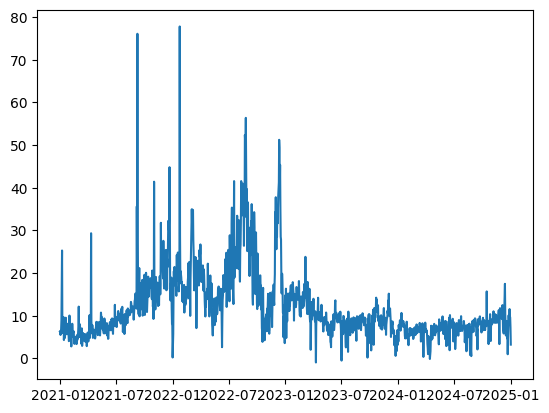

In [534]:
plt.plot(full_df.reset_index(inplace=False)["Date"],full_df['Daily'])